In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_songs_dpath = '../data/wav_files/'
genres = os.listdir(all_songs_dpath)
genre_dirs = [all_songs_dpath+d + '/' for d in os.listdir(all_songs_dpath)]
genre_song_dict = {}
for genre, genre_path in zip(genres,genre_dirs):
    genre_song_dict[genre] = [genre_path+song for song in os.listdir(genre_path) ]
{k:len(v) for k,v in genre_song_dict.items()}

{'acoustic': 82,
 'alternative': 93,
 'blues': 88,
 'classical': 74,
 'country': 84,
 'dance': 92,
 'Electronic': 94,
 'hardcore': 50,
 'hip-hop': 76,
 'indie': 86,
 'jazz': 71,
 'Metal': 90,
 'punk': 91,
 'rap': 84,
 'reggae': 85,
 'rnb': 95,
 'rock': 93}

In [20]:
def generate_mels(song):
    corr = (48000/song['sample_rate'])
    n_param = int(1000/corr)
    if song['sample_rate'] ==44100:
        song['raw_data'] = song['raw_data'][:len(song['raw_data'])-1000]
    S = librosa.feature.melspectrogram(y=song['raw_data'], sr= song['sample_rate'], n_fft=n_param,n_mels=128, 
                                       win_length=n_param,hop_length=n_param,fmax = 20000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    np.save(song['file_path'],S_dB)

In [21]:
def generate_dict(file, op_path = '../data/song_mels/'):
    
    sound = AudioSegment.from_file(file)
    wname = mktemp('.wav')
    sound.export(wname, format="wav") 
    FS, data = wavfile.read(wname)
    
    genre = file.split('/')[3]
    artist = file.split('/')[-1].split('.wav')[0].split('_')[0]
    song = file.split('/')[-1].split('.wav')[0].split('_')[1]
    single_chan_data = np.array(data,dtype = np.float32)
    if len(data.shape) == 2:
        single_chan_data = np.array(data[:,0],dtype = np.float32)

    song_dict = []
    for i in range(int((len(data)/FS)//60)):
        os.makedirs('{0}{1}/'.format(op_path,genre), exist_ok=True)
        fn = '{0}{1}/{2}_{3}_part{4}'.format(op_path, genre,artist,song, str(i+1))
        song_part_data = single_chan_data[60*i*FS:(i+1)*60*FS]
        part_dict = {'genre':genre,'sample_rate':FS, 'artist':artist, 'length':len(single_chan_data),
                     'song_name':song, 'raw_data':song_part_data, 'part':i+1,'file_path': fn}
        generate_mels(part_dict)

        song_chars = {i:part_dict[i] for i in part_dict if i!='raw_data'}
        song_dict.append(song_chars)
    os.remove(wname)
    return song_dict 

In [11]:
all_songs_dict = []
for genre in genre_song_dict.keys():
    for file in genre_song_dict[genre]:
        all_songs_dict.extend(generate_dict(file))

In [12]:
df_songs = pd.DataFrame(all_songs_dict)
df_songs.to_csv('../data/all_songs.csv', index = False)
df_songs.sample(5)

,genre,sample_rate,artist,length,song_name,part,file_path
5267,rock,44100,Linkin Park,9147392,What I've Done,2,../data/song_mels/rock/Linkin Park_What I've D...
1888,dance,44100,Lady Gaga,25157632,Telephone (feat. Beyoncé),6,../data/song_mels/dance/Lady Gaga_Telephone (f...
2949,indie,48000,Juzhin,11749669,Railways,3,../data/song_mels/indie/Juzhin_Railways_part3
3163,jazz,44100,Amy Winehouse,7418880,Love Is a Losing Game,1,../data/song_mels/jazz/Amy Winehouse_Love Is a...
4019,punk,44100,Sex Pistols,8147968,Bodies,2,../data/song_mels/punk/Sex Pistols_Bodies_part2


In [2]:
def prep_df(df):
    df['genre_corr'] = df['genre'].apply(lambda x:'hip-hop' if x in ['hip-hop','rap'] else x)
    df['genre_corr'] = df['genre_corr'].apply(lambda x:'metal' if x in ['hardcore','Metal'] else x)
    df['genre_corr'] = df['genre_corr'].apply(lambda x:'rock' if x in ['rock','punk'] else x)
    df = df[~df.genre.isin(['indie', 'blues', 'alternative'])]
    return df

In [3]:
df_songs = pd.read_csv('../data/all_songs.csv')
df_songs = prep_df(df_songs)

In [4]:
df_songs.genre_corr.value_counts()

rock          640
hip-hop       616
metal         559
classical     464
Electronic    368
rnb           353
dance         345
jazz          304
reggae        301
acoustic      288
country       252
Name: genre_corr, dtype: int64

In [5]:
all_songs=[]
rem_songs = []
for file in df_songs.file_path.to_list():
    song = np.load(file+'.npy')
    if song.shape[1] >2881:
        song = song[:,:2881]
    elif song.shape[1] <2881:
        song = np.pad(song, ((0,0),(0,2881-song.shape[1])), 'constant')
    song = song.reshape(-1,1)
    
    all_songs.append(song)
X = np.array(all_songs)
X.shape

(4490, 368768, 1)

In [6]:
df_songs_fil = df_songs[~df_songs.file_path.isin(rem_songs)]
y = df_songs_fil.genre_corr.astype('category').cat.codes.values
# y = keras.utils.to_categorical(y, num_classes=17, dtype='float32')
labels = df_songs_fil.genre_corr.astype('category')
y.shape

(4490,)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
melspectrogram=X.reshape(X.shape[0],-1)
scaler.fit(melspectrogram)
normalized_melspectrogram = scaler.transform(melspectrogram)

features_convolution = np.reshape(normalized_melspectrogram,(X.shape[0],128, -1,1))
features_convolution.shape[1:]

(128, 2881, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features_convolution, y, test_size=0.2, random_state=42, )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
gc.collect()
X_train.shape,X_test.shape, X_val.shape


((3232, 128, 2881, 1), (898, 128, 2881, 1), (360, 128, 2881, 1))

In [10]:
cnn_model = keras.Sequential()
#1
cnn_model.add(keras.layers.Conv2D(64, (3,3), input_shape=features_convolution.shape[1:], name = 'conv1'))

cnn_model.add(keras.layers.Activation('relu', name = 'act1'))
cnn_model.add(keras.layers.BatchNormalization( axis = 3))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name = 'mp1'))
cnn_model.add(keras.layers.Dropout(0.1, name = 'do1'))
#2
cnn_model.add(keras.layers.Conv2D(128, (3, 3)))
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.BatchNormalization( axis = 3))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), padding='same'))
cnn_model.add(keras.layers.Dropout(0.1))
#3

cnn_model.add(keras.layers.Conv2D(128, (3, 3)))

cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.BatchNormalization( axis = 3))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), padding='same'))
cnn_model.add(keras.layers.Dropout(0.1))
#4
cnn_model.add(keras.layers.Conv2D(128, (3, 3)))

cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.BatchNormalization( axis = 3))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), padding='same'))
cnn_model.add(keras.layers.Dropout(0.1))

cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(11))
cnn_model.add(keras.layers.Activation('softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

checkpoint_filepath = '../data//models/cnn_model/'
os.makedirs(checkpoint_filepath, exist_ok=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_cnn = cnn_model.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], 
                             verbose = 0, batch_size = 16, callbacks =[model_checkpoint_callback] )
gc.collect()

3295

In [11]:
crnn_model = keras.Sequential()
#1
#1
crnn_model.add(keras.layers.Conv2D(64, (3,3), input_shape=features_convolution.shape[1:], name = 'conv1'))

crnn_model.add(keras.layers.Activation('relu', name = 'act1'))
crnn_model.add(keras.layers.BatchNormalization( axis = 3))
crnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name = 'mp1'))
crnn_model.add(keras.layers.Dropout(0.1, name = 'do1'))
print(crnn_model.layers[-1].output_shape)
#2
crnn_model.add(keras.layers.Conv2D(128, (3, 3)))
crnn_model.add(keras.layers.Activation('relu'))
crnn_model.add(keras.layers.BatchNormalization( axis = 3))
crnn_model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), padding='same'))
crnn_model.add(keras.layers.Dropout(0.1))
print(crnn_model.layers[-1].output_shape)
#3

crnn_model.add(keras.layers.Conv2D(128, (3, 3)))
crnn_model.add(keras.layers.Activation('relu'))
crnn_model.add(keras.layers.BatchNormalization( axis = 3))
crnn_model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), padding='same'))
crnn_model.add(keras.layers.Dropout(0.1))
print(crnn_model.layers[-1].output_shape)
#4
crnn_model.add(keras.layers.Conv2D(128, (3, 3)))
crnn_model.add(keras.layers.Activation('relu'))
crnn_model.add(keras.layers.BatchNormalization( axis = 3))
crnn_model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), padding='same'))
crnn_model.add(keras.layers.Dropout(0.1))
crnn_model_shape = crnn_model.layers[-1].output_shape


crnn_model.add(keras.layers.Reshape((crnn_model_shape[3], crnn_model_shape[2])))
print(crnn_model.layers[-1].output_shape)
crnn_model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, input_shape=(1,128, 30), return_sequences=True, )))
crnn_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, input_shape=(1,128,30), return_sequences=False)))
crnn_model.add(keras.layers.Dense(11))
crnn_model.add(keras.layers.Activation('softmax'))

crnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

checkpoint_filepath = '../data//models/crnn_model/'
os.makedirs(checkpoint_filepath, exist_ok=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_crnn = crnn_model.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], 
                             verbose = 0, batch_size = 16, callbacks =[model_checkpoint_callback] )
gc.collect()

(None, 63, 1440, 64)
(None, 21, 480, 128)
(None, 5, 120, 128)
(None, 128, 30)


1444

In [12]:
pred_cnn = np.argmax( cnn_model.predict(X_test), axis=1)
accuracy_cnn = np.round(accuracy_score(y_test,pred_cnn)*100,2)
pred_crnn = np.argmax( crnn_model.predict(X_test), axis=1)
accuracy_crnn = np.round(accuracy_score(y_test,pred_crnn)*100,2)
print('The accuracy of CNN model is {}% and CRNN Model is {}%'.format(accuracy_cnn,accuracy_crnn))

The accuracy of CNN model is 58.24% and CRNN Model is 60.69%


In [44]:
def plot_heatmap_mat(y_test,pred,classes,normalize=False, ax=None ):
    sns.set_context("poster", rc={"font.size":14, 'figure.facecolor':'w'})
    sns.set({'figure.facecolor':'w'})
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',cbar_kws={"shrink": 0.5},
                    linewidths=.1, ax=ax,annot_kws={"fontsize":12})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        ax.tick_params('both', labelsize=14)
        ax.set_ylabel('Actual label', fontsize = 16)
        ax.set_xlabel('Predicted label', fontsize = 16)
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',cbar_kws={"shrink": 0.5},
                    linewidths=.2, ax= ax,annot_kws={"fontsize":12})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        ax.tick_params('both', labelsize=14)
        plt.yticks(fontsize=14)
        ax.set_ylabel('Actual label', fontsize = 16)
        ax.set_xlabel('Predicted label', fontsize = 16)
        return plot

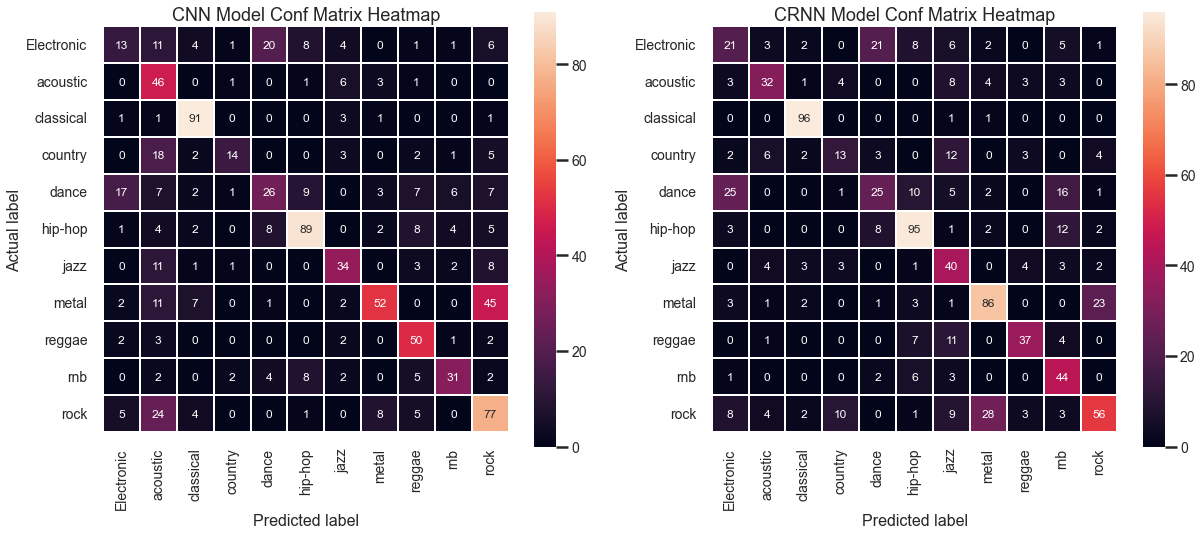

In [45]:
fig, [ax1,ax2] = plt.subplots( nrows = 1, ncols = 2,figsize=(20,16),facecolor='white')

plot_heatmap_mat(y_test,pred_cnn,normalize=False,classes =list(labels.cat.categories), ax=ax1)
ax1.set_title('CNN Model Conf Matrix Heatmap', fontsize = 18)
plot_heatmap_mat(y_test,pred_crnn,normalize=False,classes =list(labels.cat.categories), ax=ax2)
ax2.set_title('CRNN Model Conf Matrix Heatmap', fontsize = 18)
plt.show()

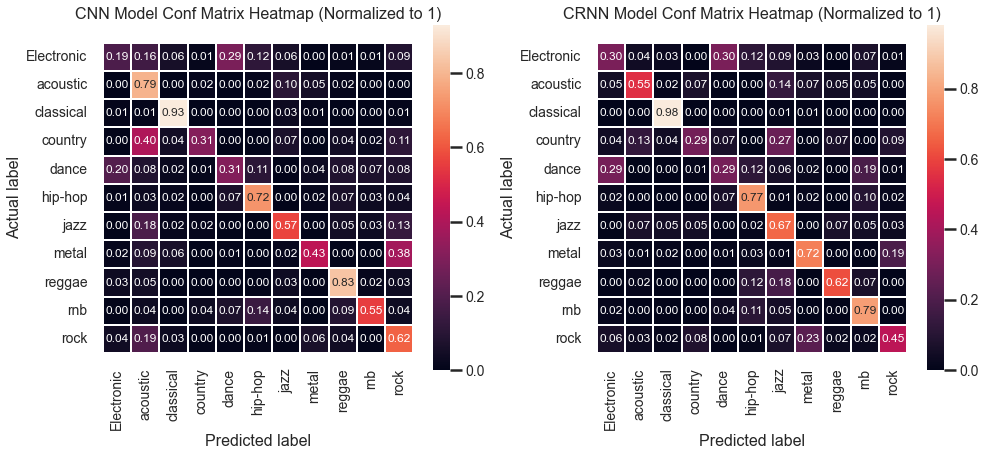

In [46]:
fig, [ax1,ax2] = plt.subplots( nrows = 1, ncols = 2,figsize=(14,10),facecolor='white')

plot_heatmap_mat(y_test,pred_cnn,normalize=True,classes =list(labels.cat.categories), ax=ax1)
ax1.set_title('CNN Model Conf Matrix Heatmap (Normalized to 1)\n', fontsize = 16)

plot_heatmap_mat(y_test,pred_crnn,normalize=True,classes =list(labels.cat.categories), ax=ax2)
ax2.set_title('CRNN Model Conf Matrix Heatmap (Normalized to 1)\n', fontsize = 16)
plt.tight_layout()
plt.savefig('../data/images/model_comparison_norm_heatmap.jpg', dpi=300, format = 'jpg')


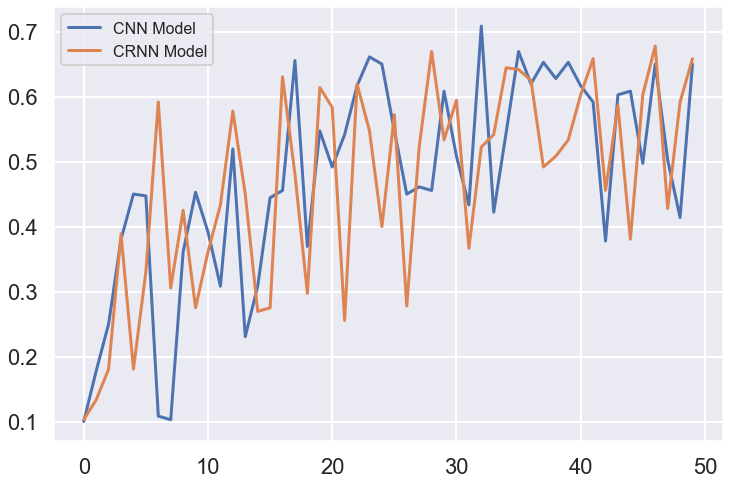

In [18]:
sns.set_context("poster", rc={"font.size":14, 'figure.facecolor':'w'})
sns.set({'figure.facecolor':'w'})
plt.figure(figsize = (12,8))
pd.DataFrame(history_cnn.history)['val_accuracy'].plot(label='CNN Model')
pd.DataFrame(history_crnn.history)['val_accuracy'].plot(label= 'CRNN Model')
plt.legend(fontsize = 16)